<a href="https://colab.research.google.com/github/simoneminorr/lab_scraping/blob/main/group_lab_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Web Scraping

Lots of great data is available online, but available through inconveniently formatted web pages. When this is the case, sometimes you can simply copy and paste the data into a .csv file and go on with your life. But if there are many records to parse and combine into a dataset, that might be impossible. Can we automate the collection of data from online sources?

This is called web scraping. Broadly speaking: Web scraping is legal, but what you plan to do with the results of your scraping might not be. In general, most sites do not want you to scrape them at this point, but there is not really a way to stop you if you are sufficiently motivated. Be careful to use server resources respectfully (not too many requests per unit time), think seriously about privacy concerns, and be careful who you share your work with and how it is used.

We'll be scraping data about used cars in Charlottesville from Craigslist, particularly this page: https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0

We'll use the `requests` package to get web pages off the Internet and into Python. Again, we'll use a header with a user-agent that masks our true identity so that we're not rejected by the server. This particular url points to the car listings for Craigslist in Charlottesville. To use requests, you pass a `url` for the page you want and a `header` that controls how you appear to the server to `requests.get`:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'} # How we wish to appear to CL
url = 'https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0' # The page we want to scrape
raw = requests.get(url,headers=header) # Get page

Now that we have that particular page available locally, we want to **parse** it and get results from it. To do that, we can use a package called `beautifulSoup` or `bs4`.

What does `beautifulSoup` do for us? Let's go to the web page of interest. You probably see something like this:

![Listings](./src/craigslist.png "Craigslist")

But if you "view page source" -- which is CTRL+U -- in Chrome, you see what the computer sees:

![Listings](./src/craigslist_source.png "Craigslist")

Since your web browser needs lots of instructions about how to render the text, pictures, and other content on your web page, there are a lot of clues about where the data live and how to extricate them from a page. These clues are called **tags**. If you wander the source for the search page on cars, you see a particular `class = "cl-static-search-result"` term appear attached to each listing:

![Listings](./src/listing.png "Craigslist")

This structure can be exploited to search the page for information. This kind of detective work -- looking at the page source, finding the interesting tags, and then searching the page with `beautifulSoup` -- is the basic job of web scraping.

What I do is look at the rendered page, find the text I want and copy it, then search for that text in the HTML code that the computer sees. When I find the text I want, I look for the tag nearby. Here, it's `cl-static-search-result`: That's what I'll want beautifulSoup to search for.

The following code chunk takes the raw content from `requests` and turns it into a beautifulSoup object, which can search the page and return results for us:

In [ ]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings of the kind we want

Why is the argument `class_` and not just `class`? The word `class` is a reserved keyword for Python, and cannot be used by anyone else, similar to `True` and `False`. But since we want the `class = "cl-static-search-result"` terms, we need to use the `class_` argument to the `.find_all` method.

The `.find_all` function dredges the entire page and finds all the instances of `class = "cl-static-search-result"`, resulting in a list of entries. We can then parse the entries.

Parsing the entries can be a challenge! We have to go back to what a listing looks like, and look at the tags within the listing. They're typically `div` tags with a `class` like price or location. You then have to experiment a bit with `.find` and the HTML to make sure you're getting the information you want. For each listing, the `.find` method to search within the listing record for specific information, but it's typically still wrapped in the tag. To get the real information we want, we can then use `.get_text()`. I end up using a code chunk to experiment and play with a record to make sure I'm getting as close to what I want as possible.

In the code below, two more things happen. You don't need to do them in your work, but they're helpful to know about.

First, I would like to get the brand of the car from the post title, if possible. To do this, I split the title into words using `title.split()`, and then I use a list comprehension to look over every word in the title and check whether it appears in the `brands` list.

Second, I would like to get the year the car was built, if possible, so I can determine the vehicle's age. To do this, I use a thing called **regular expressions** that provides a language for expressing patterns. Do I remember how to do this off the top of my head? No, I read a few pages in a book and looked on StackOverflow for answers. Roughly, in order to express the idea "any year starting with 20xx," you can write `20[0-9][0-9]`, and for "any year starting with 19xx," you can write `19[0-9][0-9]`. The `[0-9]`'s act as wildcards for any digit. This allows me to use the `re` package to find any instances of year-like numbers in the title text, using `re.search(r'20[0-9][0-9]|19[0-9][0-9]', title )`.

This is all nested in a for-loop over the listings, and the data is appended to a list.

In [ ]:
import re # Regular expressions

brands = ['honda', 'dodge','toyota','ford','tesla','gmc','jeep','bmw','mitsubishi','mazda',
          'volvo','audi','volkswagen','chevy','chevrolet','acura','kia','subaru','lexus',
          'cadillac','buick','porsche','infiniti']

data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    # Get brand from the title string:
    words = title.split()
    hits = [word for word in words if word in brands] # Find brands in the title
    if len(hits) == 0:
        brand = 'missing'
    else:
        brand = hits[0]
    # Get years from title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title ) # Find year references
    if regex_search is None: # If no hits, record year as missing value
        year = np.nan
    else: # If hits, record year as first match
        year = regex_search.group(0)
    #
    data.append({'title':title,'price':price,'year':year,'link':link,'brand':brand})


With the data scraped from Craigslist, we can put it in a dataframe and wrangle it. Of course, price and year come in as text, not numbers, and need to be typecast/coerced:

In [ ]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['year'] = pd.to_numeric(df['year'],errors='coerce')
df['age'] = 2025-df['year']
print(df.shape)
df.to_csv('./src/craigslist_cville_cars.csv') # Save data in case of a disaster
df.head()

(70, 6)


OSError: Cannot save file into a non-existent directory: 'src'

With the data in and wrangled, we can now do some analysis:

In [ ]:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()
print(df['age'].describe())
df['age'].hist(grid=False)
plt.show()

In [ ]:
# Price by brand:
df.loc[:,['price','brand']].groupby('brand').describe()

In [ ]:
# Age by brand:
df.loc[:,['age','brand']].groupby('brand').describe()

In [ ]:
ax = sns.scatterplot(data=df, x='age', y='price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [ ]:
df['log_price'] = np.log(df['price'])
df['log_age'] = np.log(df['age'])

ax = sns.scatterplot(data=df, x='log_age', y='log_price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

print(df.loc[:,['log_price','log_age']].cov())
print(df.loc[:,['log_price','log_age']].corr())

## The Lab:


1. Pick something else on Craigslist besides used cars: Musical instruments, roommates, antiques, etc. Look at the search page and its source code. Record which fields/data you would like to gather, and what kinds of basic EDA you'd do with it.
2. Get your search results of interest using `requests` and extract data from them using `beautifulSoup`, using code similar to what's above.
3. Wrangle your data into a dataframe and do some basic descriptions and plots. Try to find some interesting relationships or stories to tell about your data.
4. Document all your work as code and markdown blocks in this notebook.

We chose boats

In [ ]:
#importing packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'}
url = 'https://charlottesville.craigslist.org/search/boo?purveyor=owner#search=2~gallery~3' # The page we want to scrape
raw = requests.get(url,headers=header) # Get page

In [ ]:
# Parsing the data
from bs4 import BeautifulSoup as soup
bsObj = soup(raw.content,'html.parser')
listings = bsObj.find_all(class_="cl-static-search-result")

In [ ]:
# Display all titles in the boat DataFrame
for index, row in df.iterrows():
    print(row['title'])

2016 chevy silverado 2500 4wd truck
2013 subaru outback
2014 audi a6
2019 chevy equinox ls
2010 international 400 box truck
1955 chevrolet 210 2dr sedan
acura mdx 2007 sport (technology package) (price is negotiable)
2014 jeep wrangler sport
2017 ford fiesta titanium, 43,000 miles.
work van
2002 ford ranger (look)
subaru forester 2014
toyota prius incredible mpg
2008 lexus rx350 suv awd
2012 hyundai veloster
2003 honda pilot
clean
2016 bmw x3 28d
2006 volvo s60 2.5t
2012 hyundai sonata 55k original miles
2012 honda civic lx
2021 ford bronco outerbanks
chevrolet blazers group of 3
for sale: 2004 bmw 645ci coupe with dinan powertrain modifications
hummer 2008 h3
2005 pt cruiser convertible
2000 jeep wrangler 4.0 manual 4x4
toyota tacoma 2000
2015 sienna le
1968 mercedes benz 280 se 280se
dodge ram 3500 truck-2016
2013 honda odyssey ex must call
2003 ford explorer xlt 4x4
fiat 500 pop convertible
clean 2006 jeep lj bulletproof 4.0
project/parts car
1998 subaru outback
2016 freightliner sd

In [ ]:
import re #importing regular expressions

types =  [ 'bass tracker tournament', 'boat trailer', 'galaxy',
'mainship',
'bass boat',
'kayak/paddle/lifejacket',
'wave armor',
'rinker',
'canoe',
'electric boat',
'paddle boat',
'baja h2x',
'kayaks',
'jet ski',
'nucanoe',
'canoe',
'kayak',
'bayliner',
'1993 nitro 190dc ($1000 for boat, motor and trailer)',
'jon boat',
'sailboats',]

data = []
for k in range (len(listings)):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    # getting type from the title string
    words = title.split()
    hits = [word for word in words if word in types]
    if len(hits) == 0:
        type = 'missing'
    else:
        type = hits[0]
    # Get years from title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title ) # Find year references
    if regex_search is None: # If no hits, record year as missing value
        year = np.nan
    else: # If hits, record year as first match
        year = regex_search.group(0)
    data.append({'title':title,'price':price,'year':year,'link':link,'type':type})

In [ ]:
import os

#wrangling the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['year'] = pd.to_numeric(df['year'],errors='coerce')
df['age'] = 2025-df['year']
print(df.shape)

#create dictioinary ig it does not exist
output_dir = './src'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

df.to_csv('./src/craigslist_cville_boats.csv')
df.head()

(30, 6)


,title,price,year,link,type,age
0,coleman mariner 15 canoe,220,NaN,https://charlottesville.craigslist.org/boa/d/g...,canoe,NaN
1,1987 bass tracker tournament tx-17 restored,3500,1987.0,https://charlottesville.craigslist.org/boa/d/c...,missing,38.0
2,1994 14.5ft northwood 1467lw boat + boat trail...,4500,1994.0,https://charlottesville.craigslist.org/boa/d/m...,missing,31.0
3,1987 galaxy,1000,1987.0,https://charlottesville.craigslist.org/boa/d/c...,galaxy,38.0
4,reduced! 2009 mainship pilot 31,135000,2009.0,https://charlottesville.craigslist.org/boa/d/i...,mainship,16.0


count        30.000000
mean       6719.833333
std       24642.605189
min         125.000000
25%         300.000000
50%        1150.000000
75%        3000.000000
max      135000.000000
Name: price, dtype: float64


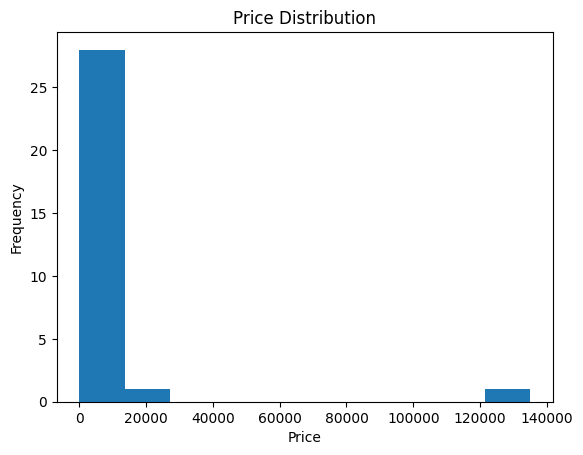

count     7.000000
mean     27.428571
std       9.589180
min      16.000000
25%      18.500000
50%      31.000000
75%      35.000000
max      38.000000
Name: age, dtype: float64


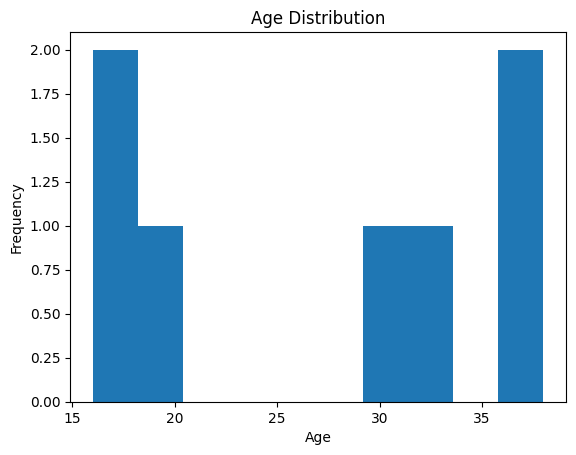

In [ ]:
#analysis of the data
print(df['price'].describe())
df['price'].hist(grid=False)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()
print(df['age'].describe())
df['age'].hist(grid=False)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

Based on the data we scraped, there seemingly is an interesting relationship between the price of a boat and the frequency it was bought at. Telling from the data, we can see that boats that are below $20000 are purchased at a higher frequency than that of the boats that are priced higher.

In [ ]:
# Price by type
df.loc[:,['price','type']].groupby('type').describe()

price                                                  \
                        count           mean          std       min       25%   
type                                                                            
bayliner                  1.0    4000.000000          NaN    4000.0    4000.0   
canoe                     4.0     242.500000   109.048919     150.0     187.5   
galaxy                    1.0    1000.000000          NaN    1000.0    1000.0   
kayak                     5.0     345.000000   215.348555     125.0     250.0   
kayak/paddle/lifejacket   1.0     200.000000          NaN     200.0     200.0   
kayaks                    1.0     500.000000          NaN     500.0     500.0   
mainship                  1.0  135000.000000          NaN  135000.0  135000.0   
missing                  12.0    3991.666667  6744.925141     200.0    1275.0   
nucanoe                   1.0    1300.000000          NaN    1300.0    1300.0   
rinker                    2.0    3500.000000     0.000000    3500.0    3500.0   
sailboats                 1.0    2000.000000          NaN    2000.0    2000.0   

                                                       
                              50%       75%       max  
type                                                   
bayliner                   4000.0    4000.0    4000.0  
canoe                       210.0     265.0     400.0  
galaxy                     1000.0    1000.0    1000.0  
kayak                       300.0     350.0     700.0  
kayak/paddle/lifejacket     200.0     200.0     200.0  
kayaks                      500.0     500.0     500.0  
mainship                 135000.0  135000.0  135000.0  
missing                    2350.0    3125.0   25000.0  
nucanoe                    1300.0    1300.0    1300.0  
rinker                     3500.0    3500.0    3500.0  
sailboats                  2000.0    2000.0    2000.0

Looking here at the data based on the boats, we can see that the most expensive item that is sold on craiglist is a mainship (in fact there is only 1) and the average cheapest appliance are kayak/paddle/lifejacket combo (which was also only sold once all together). The missing catergorization of boats makes up the bulk of listings (12) with kayak being the second most frequent with its total count of five and with a count of 4, canoes are the third most frequent listing.

In [ ]:
# Age by type
df.loc[:,['age','type']].groupby('type').describe()

age                                           
                        count   mean  std   min    25%   50%   75%   max
type                                                                    
bayliner                  1.0  17.00  NaN  17.0  17.00  17.0  17.0  17.0
canoe                     0.0    NaN  NaN   NaN    NaN   NaN   NaN   NaN
galaxy                    1.0  38.00  NaN  38.0  38.00  38.0  38.0  38.0
kayak                     0.0    NaN  NaN   NaN    NaN   NaN   NaN   NaN
kayak/paddle/lifejacket   0.0    NaN  NaN   NaN    NaN   NaN   NaN   NaN
kayaks                    0.0    NaN  NaN   NaN    NaN   NaN   NaN   NaN
mainship                  1.0  16.00  NaN  16.0  16.00  16.0  16.0  16.0
missing                   4.0  30.25  7.5  20.0  28.25  31.5  33.5  38.0
nucanoe                   0.0    NaN  NaN   NaN    NaN   NaN   NaN   NaN
rinker                    0.0    NaN  NaN   NaN    NaN   NaN   NaN   NaN
sailboats                 0.0    NaN  NaN   NaN    NaN   NaN   NaN   NaN

Due to substaintal missing data relative to all the listings there cannot be a clear conclusion made about the ages of the boats listed. However we can see that the boat sold at the highest price is the newest.

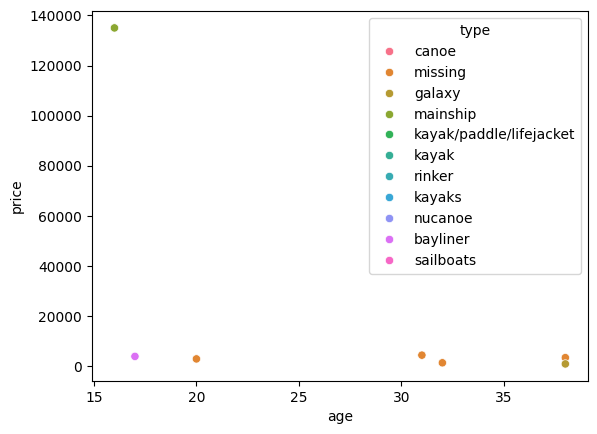

In [ ]:
ax = sns.scatterplot(data=df, x='age', y='price',hue='type')
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1)) # Removed as there's no legend without data points

Due again to the substaintal missing data relative to all the listings there cannot be a clear conclusion made about the ages of the boats listed. Creating a scatterplot based on that and price render difficult due to the inability to compare the missing data. However we can still see that the price is highest of the newest one/boat with the lowest age.

           log_price   log_age
log_price   2.523574 -0.399372
log_age    -0.399372  0.141171
           log_price   log_age
log_price   1.000000 -0.664454
log_age    -0.664454  1.000000


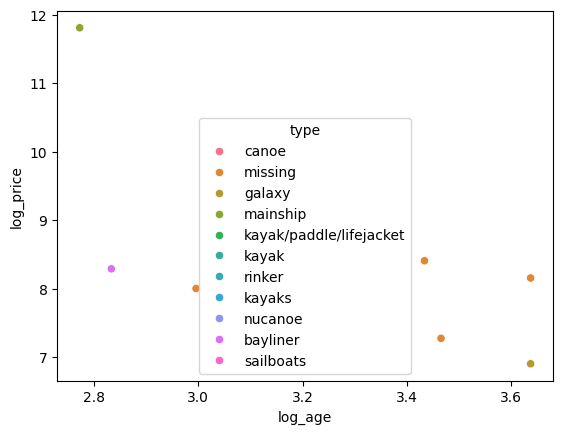

In [ ]:
df['log_price'] = np.log(df['price'])
df['log_age'] = np.log(df['age'])

ax = sns.scatterplot(data=df, x='log_age', y='log_price',hue='type')
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

print(df.loc[:,['log_price','log_age']].cov())
print(df.loc[:,['log_price','log_age']].corr())

Based on the data scraped, it was clear that there are a lot of boats that were not classified into different types adequately and some that have missing age values. If the year the boat was manufacturer is left off of the listing it creates a missing data point on our end which makes it difficult to visualize the data about the age of the boats. However, from what we can see, it seems new products can be sold for more but this is based on one listing.

In conclusion, there needs to be more listings of boats and the year of manufacturing needs to be included to make substantive claims about the boats, their prices, and their age in relation. From what we can see it seems the newer the boat, the more the seller can charge and that the values of boats stay pretty stead overtime once the vehicle is not new.